In [270]:
import numpy as np
import sympy as sp
from magnetic_field_script import magnetic_field_bar, magnetic_field_gradient
from constants import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.optimize import root_scalar


In [271]:
import numpy as np

def _as_vec3(x):
    """Return x as a 1-D length-3 float vector."""
    a = np.asarray(x, dtype=float)
    return a.reshape(-1)[:3]

def _as_col3(x):
    """Return x as a 3x1 float column (useful if you want column behavior)."""
    a = np.asarray(x, dtype=float).reshape(-1)[:3]
    return a.reshape(3,1)


In [272]:
s_sym, theta_sym = sp.symbols('s theta', real =True)
Bx_sym, By_sym, Bz_sym = sp.symbols('Bx By Bz', real=True)
gBx_sym, gBy_sym, gBz_sym = sp.symbols('gBx gBy gBz', real = True)
m1_sym, m2_sym, m3_sym = sp.symbols('m1 m2 m3', real=True)
psi_sym = sp.symbols('psi', real =True)
B_vec_sym = sp.Matrix([Bx_sym, By_sym, Bz_sym])
Bg_vec_sym = sp.Matrix([gBx_sym, gBy_sym, gBz_sym])
m_vec_sym = sp.Matrix([m1_sym, m2_sym, m3_sym])

theta_sym, phi_sym = sp.symbols('theta phi', real =True)
R_x_sym = sp.Matrix([[1, 0, 0],
                    [0, sp.cos(phi_sym), -sp.sin(phi_sym)],
                    [0, sp.sin(phi_sym), sp.cos(phi_sym)]])

R_z_sym = sp.Matrix([[sp.cos(theta_sym), -sp.sin(theta_sym), 0],
                     [sp.sin(theta_sym), sp.cos(theta_sym), 0],
                     [0,0,1]])


In [273]:
rotation_matrix = R_x_sym @ R_z_sym
dR_dtheta = rotation_matrix.diff(theta_sym)
x_vec_sym = R_x_sym @ sp.Matrix([sp.cos(theta_sym), sp.sin(theta_sym), 0])
dx_dtheta = x_vec_sym.diff(theta_sym)

In [330]:
mhat_sym = sp.Matrix([-sp.cos(psi_sym), sp.sin(psi_sym), 0])

m_mag_sym = sp.symbols('m_mag', real=True)  
dR_dtheta_mpsi = dR_dtheta * (m_mag_sym * mhat_sym) 
print(dR_dtheta_mpsi)
beam_bending_integral_psi = (dR_dtheta_mpsi.T @ B_vec_sym)[0] + (dx_dtheta.T @ Bg_vec_sym)[0]

beam_bending_integral_psi_eval = sp.lambdify(
    (phi_sym, s_sym, theta_sym, Bx_sym, By_sym, Bz_sym,
     gBx_sym, gBy_sym, gBz_sym, psi_sym, m_mag_sym),
    beam_bending_integral_psi, modules='numpy'
)

df_dtheta_psi_fn = sp.lambdify(
    (phi_sym, s_sym, theta_sym, Bx_sym, By_sym, Bz_sym,
     gBx_sym, gBy_sym, gBz_sym, psi_sym, m_mag_sym),
    sp.diff(beam_bending_integral_psi, theta_sym),
    modules='numpy'
)

df_dpsi_fn = sp.lambdify(
    (phi_sym, s_sym, theta_sym, Bx_sym, By_sym, Bz_sym,
     gBx_sym, gBy_sym, gBz_sym, psi_sym, m_mag_sym),
    sp.diff(beam_bending_integral_psi, psi_sym),
    modules='numpy'
)


Matrix([[-m_mag*sin(psi)*cos(theta) + m_mag*sin(theta)*cos(psi)], [-m_mag*sin(psi)*sin(theta)*cos(phi) - m_mag*cos(phi)*cos(psi)*cos(theta)], [-m_mag*sin(phi)*sin(psi)*sin(theta) - m_mag*sin(phi)*cos(psi)*cos(theta)]])


In [336]:
def evalulate_magnetic_field2(p_now, MAGNET_M, base_dir=np.array([-1.0,0.0,0.0])):
    p_now = np.asarray(p_now, float)
    # m_base = np.asarray(base_dir, float)
    m_base = np.array([-np.cos(0), -np.sin(0), 0.0], dtype=float)
    T = magnetic_field_bar(p_now, MU0, MAGNET_M)
    B_vec = (T @ m_base).ravel()
    test = T@np.array([1,1,1])
    ex, ey, ez = np.eye(3)
    Gx = -1*magnetic_field_gradient(p_now, ex, MU0, MAGNET_M)
    Gy = -1*magnetic_field_gradient(p_now, ey, MU0, MAGNET_M)
    Gz = -1*magnetic_field_gradient(p_now, ez, MU0, MAGNET_M)
    G = np.column_stack([(Gx @ m_base).ravel(),
                         (Gy @ m_base).ravel(),
                         (Gz @ m_base).ravel()])
    return G, B_vec

def magnetic_field_dynamic2(s_val, theta_val, p_vec, phi, debug_field=False):
    Rx = np.array([[1,0,0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi),  np.cos(phi)]], float)
    Rm_local = np.array([-np.cos(theta_val), np.sin(theta_val), 0.0], float)
    # Rm = Rx @ Rm_local
    Rm = np.array([-np.cos(0), -np.sin(0), 0.0], dtype=float)
    p_now = _as_vec3(p_vec) + float(s_val) * Rm
    G, B_vec = evalulate_magnetic_field2(p_now, MAGNET_M)
    Bg_Rm = (G @ Rm).ravel()
    if debug_field == True:
        print(f"Magnetic field: {B_vec}")
        print(f"Magnetic field gradient: {Bg_Rm}")
    return B_vec, Bg_Rm


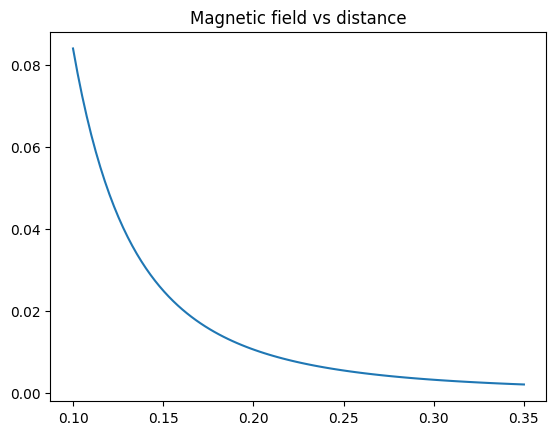

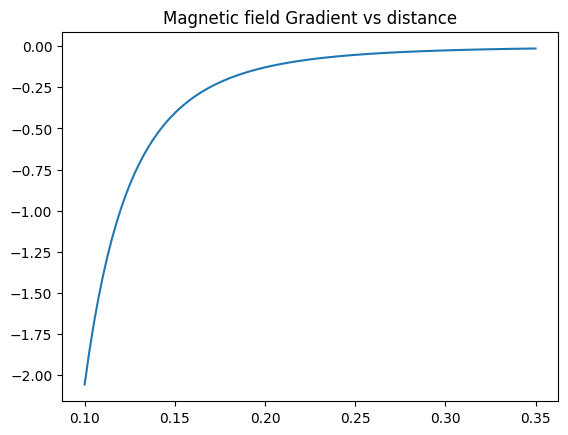

In [298]:
mag_values = []
grad_values = []
distances = np.linspace(0.1, 0.35, 100)

for py in distances:
    p_vec = np.array([0.0, py, 0.0])
    field = magnetic_field_bar(p_vec, MU0, MAGNET_M)
    field_norm = np.linalg.norm(field)
    mag_values.append(field_norm)

    grad_x = magnetic_field_gradient(p_vec, np.array([0.0,1.0,0.0]), MU0, MAGNET_M )
    grad_values.append(grad_x[1,1])
plt.figure()
plt.plot(distances, mag_values)
plt.title("Magnetic field vs distance")
plt.show()

plt.figure()
plt.plot(distances, grad_values)
plt.title("Magnetic field Gradient vs distance")
plt.show()

In [279]:
def beam_sym_to_val(s_val, theta_val, p_vec, phi, psi_ref):
    B_vec, Bg_Rm = magnetic_field_dynamic2(s_val, theta_val, p_vec, phi)
    Bx, By, Bz = map(float, np.ravel(B_vec))
    gBx, gBy, gBz = map(float, np.ravel(Bg_Rm))
    return float(beam_bending_integral_psi_eval(
        phi, float(s_val), float(theta_val),
        Bx, By, Bz, gBx, gBy, gBz,
        float(psi_ref), float(magnetisation)
    ))


In [ ]:
def rhs(s_val, y, p_vec, phi, psi_ref):
    return np.array([
        y[1],
        -(A_val/(E_val*I_val)) * beam_sym_to_val(s_val, y[0], p_vec, phi, psi_ref)
    ], dtype=float)

def shooting_fun(k_guess, p_vec, psi_ref, phi):
    sol = solve_ivp(rhs,
                    (0.0, LENGTH),
                    y0=[0.0, float(k_guess)],
                    t_eval=[LENGTH],
                    max_step=LENGTH/200,
                    args=(p_vec, phi, psi_ref))
    return float(sol.y[1, -1])

def shooting_solve(ks, s_steps, p_vec, phi, psi_ref):
    vals = [shooting_fun(k, p_vec, psi_ref, phi) for k in ks]
    idx = np.where(np.sign(vals[:-1]) * np.sign(vals[1:]) < 0)[0]
    if len(idx)==0:
        j = int(np.argmin(np.abs(vals))); k_star = ks[j]
        try:
            k_b = ks[min(j+1, len(ks)-1)]
            res = root_scalar(shooting_fun, x0=k_star, x1=k_b, method='secant', args=(p_vec, psi_ref, phi))
            print("1")
            if res.converged: k_star = float(res.root)

        except Exception:
            pass
    else:
        k_a, k_b = ks[idx[0]], ks[idx[0]+1]
        res = root_scalar(shooting_fun, bracket=(k_a, k_b), method='brentq', args=(p_vec, psi_ref, phi))
        k_star = float(res.root) if res.converged else float(0.5*(k_a+k_b))
        print("2")

    s_grid = np.linspace(0.0, LENGTH, int(s_steps))
    solution_beam = solve_ivp(lambda s, y: rhs(s, y, p_vec, phi, psi_ref),
                              (0.0, LENGTH),
                              y0=[0.0, k_star],
                              t_eval=s_grid,
                              max_step=LENGTH/200)
    theta_bar_tip = float(solution_beam.y[0, -1])  
    return theta_bar_tip, k_star, solution_beam

def m_dir_from_psi(psi: float, phi: float) -> np.ndarray:
    base = np.array([-np.cos(psi), np.sin(psi), 0.0], float)
    Rx = np.array([[1,0,0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi),  np.cos(phi)]], float)
    return Rx @ base

def simulate_beam(ks, s_steps, psi, p_vec, phi):
    vbar_tip, root, sol = shooting_solve(ks, s_steps, p_vec, phi, psi)
    theta_vec_tip = vbar_tip * m_dir_from_psi(psi, phi)
    return theta_vec_tip, vbar_tip, root, sol


2


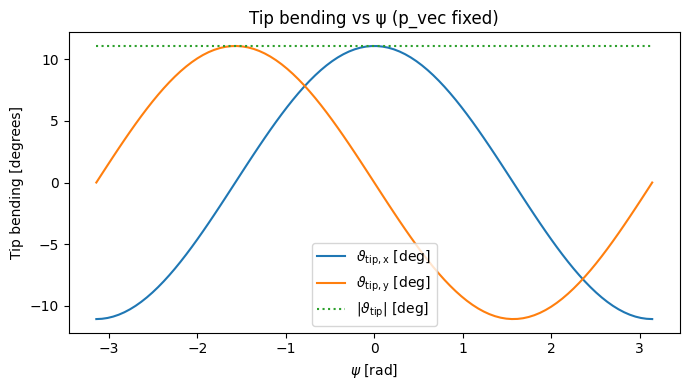

v̄_tip (scalar) = -0.193634
|θ_tip(ψ)| min/max over sweep = 0.193634 / 0.193634


In [329]:
def sweep_tip_vs_psi(ks, s_steps, p_vec, psi_grid, phi, psi):
    _, vbar_tip, _, _ = simulate_beam(ks, s_steps, psi, p_vec=p_vec, phi=phi)
    tips = np.array([vbar_tip * m_dir_from_psi(psi, phi) for psi in psi_grid])
    tip_mag = np.linalg.norm(tips, axis=1)  

    plt.figure(figsize=(7,4))
    plt.plot(psi_grid, np.rad2deg(tips[:,0]), label=r"$\vartheta_{\rm tip,x}$ [deg]")
    plt.plot(psi_grid, np.rad2deg(tips[:,1]), label=r"$\vartheta_{\rm tip,y}$ [deg]")
    plt.plot(psi_grid, np.rad2deg(tip_mag),  label=r"$|\vartheta_{\rm tip}|$ [deg]", linestyle=":")
    plt.xlabel(r"$\psi$ [rad]")
    plt.ylabel("Tip bending [degrees]")
    plt.title("Tip bending vs ψ (p_vec fixed)")
    plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"v̄_tip (scalar) = {vbar_tip:.6g}")
    print(f"|θ_tip(ψ)| min/max over sweep = {tip_mag.min():.6g} / {tip_mag.max():.6g}")
psi_grid = np.linspace(-np.pi, np.pi, 100)
ks = np.linspace(-500, 500, 81)
s_steps = 200
p_vec = np.array([0.0, 0.2, 0.0], float)
phi = 0
psi=0
sweep_tip_vs_psi(ks, s_steps, p_vec, psi_grid, phi, psi)


In [331]:
def f_theta_analytic(s_val, theta_val, psi, p_vec, phi):
    B_vec, Bg_Rm = magnetic_field_dynamic2(s_val, theta_val, p_vec, phi)
    Bx, By, Bz = map(float, np.ravel(B_vec))
    gBx, gBy, gBz = map(float, np.ravel(Bg_Rm))
    return -(A_val/(E_val*I_val)) * float(df_dtheta_psi_fn(
        phi, float(s_val), float(theta_val),
        Bx, By, Bz, gBx, gBy, gBz,
        float(psi), magnetisation
    ))

def f_psi_analytic(s_val, theta_val, psi, p_vec, phi):
    B_vec, Bg_Rm = magnetic_field_dynamic2(s_val, theta_val, p_vec, phi)
    Bx, By, Bz = map(float, np.ravel(B_vec))
    gBx, gBy, gBz = map(float, np.ravel(Bg_Rm))
    return -(A_val/(E_val*I_val)) * float(df_dpsi_fn(
        phi, float(s_val), float(theta_val),
        Bx, By, Bz, gBx, gBy, gBz,
        float(psi), magnetisation
    ))


In [332]:
def tip_sensitivity_with_shooting(solution_beam, psi, p_vec, phi):
    """
    Returns dθ(L)/dψ under the terminal constraint θ'(L)=0.
    Integrates u and w tangents along the stored θ(s) trajectory.
    """
    s_grid = solution_beam.t
    theta_grid = np.asarray(solution_beam.y)[0]

    def rhs_pair(s, y):
        theta_s = np.interp(s, s_grid, theta_grid)
        u, u1, w, w1 = y
        ft = f_theta_analytic(s, theta_s, psi, p_vec, phi)
        fp = f_psi_analytic  (s, theta_s, psi, p_vec, phi)
        return np.array([u1, ft*u + fp, w1, ft*w], dtype=float)

    y0 = [0.0, 0.0, 0.0, 1.0]
    sol = solve_ivp(rhs_pair, (s_grid[0], s_grid[-1]), y0, t_eval=[s_grid[-1]], max_step=LENGTH/800)
    U = np.asarray(sol.y)[:, -1]
    uL, u1L, wL, w1L = map(float, U)

    dk_dpsi = - u1L / (w1L + 1e-12)
    dthetaL_dpsi = uL + wL * dk_dpsi
    return dthetaL_dpsi


In [ ]:
mhat_ref_sym = sp.Matrix([-1, 0, 0])     
vbar_sym = ((dR_dtheta * (m_mag_sym * mhat_ref_sym)).T @ B_vec_sym)[0] + (dx_dtheta.T @ Bg_vec_sym)[0]

vbar_eval_fn = sp.lambdify(
    (phi_sym, s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m_mag_sym),
    vbar_sym, modules='numpy'
)

dvbar_dtheta_fn = sp.lambdify(
    (phi_sym, s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m_mag_sym),
    sp.diff(vbar_sym, theta_sym), modules='numpy'
)
def dmhat_dpsi(psi: float) -> np.ndarray: 
    return np.array([np.sin(psi), np.cos(psi), 0.0], dtype=float)
def vbar_at_tip(theta_L, p_vec, s_L, psi_ref=0.0, phi=phi):
    B_vec, Bg_vec = magnetic_field_dynamic2(s_L, theta_L, p_vec)
    return float(beam_bending_integral_psi_eval(
        phi, s_L, theta_L,
        B_vec[0], B_vec[1], B_vec[2],
        Bg_vec[0], Bg_vec[1], Bg_vec[2],
        psi_ref, 8e3
    ))

def dvbar_dtheta_at_tip(theta_L, p_vec, s_L, psi_ref=0.0, phi=phi):
    B_vec, Bg_vec = magnetic_field_dynamic2(s_L, theta_L, p_vec, phi)
    return float(df_dtheta_psi_fn(
        phi, s_L, theta_L,
        B_vec[0], B_vec[1], B_vec[2],
        Bg_vec[0], Bg_vec[1], Bg_vec[2],
        psi_ref, 8e3
    ))

def jacobian_tip_wrt_psi(solution_beam, psi, p_vec, *, s_L, phi):
    dthetaL_dpsi = tip_sensitivity_with_shooting(solution_beam, psi, p_vec, phi)
    theta_L = float(np.asarray(solution_beam.y)[0, -1])
    _, vbar_tip, _, _ = simulate_beam(ks, s_steps, psi=0.0, p_vec=p_vec, phi=phi)
    dvbar_dtheta_L = dvbar_dtheta_at_tip(vbar_tip, p_vec, s_L, psi_ref=0.0)
    m_hat = m_dir_from_psi(psi, phi)
    return (dvbar_dtheta_L * dthetaL_dpsi) * m_hat + vbar_tip * dmhat_dpsi(psi)


2


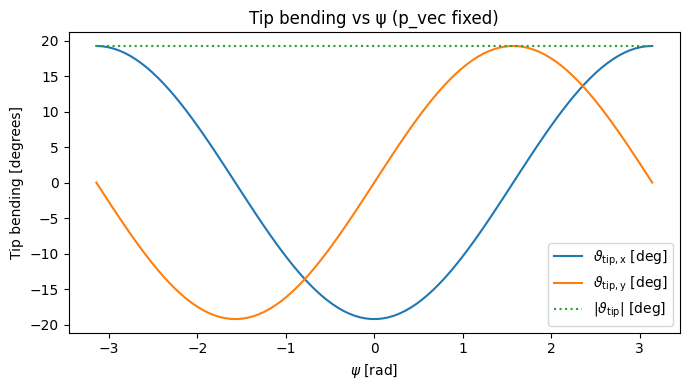

v̄_tip (scalar) = 0.335676
|θ_tip(ψ)| min/max over sweep = 0.335676 / 0.335676


In [297]:
def sweep_tip_vs_psi(ks, s_steps, p_vec, psi_grid, phi):
    _, vbar_tip, _, _ = simulate_beam(ks, s_steps, psi=0.0, p_vec=p_vec, phi=0.0)

    tips = np.array([vbar_tip * m_dir_from_psi(psi, phi) for psi in psi_grid])  # (Nψ, 3)
    tip_mag = np.linalg.norm(tips, axis=1)  

    plt.figure(figsize=(7,4))
    plt.plot(psi_grid, np.rad2deg(tips[:,0]), label=r"$\vartheta_{\rm tip,x}$ [deg]")
    plt.plot(psi_grid, np.rad2deg(tips[:,1]), label=r"$\vartheta_{\rm tip,y}$ [deg]")
    plt.plot(psi_grid, np.rad2deg(tip_mag),  label=r"$|\vartheta_{\rm tip}|$ [deg]", linestyle=":")
    plt.xlabel(r"$\psi$ [rad]")
    plt.ylabel("Tip bending [degrees]")
    plt.title("Tip bending vs ψ (p_vec fixed)")
    plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"v̄_tip (scalar) = {vbar_tip:.6g}")
    print(f"|θ_tip(ψ)| min/max over sweep = {tip_mag.min():.6g} / {tip_mag.max():.6g}")
psi_grid = np.linspace(-np.pi, np.pi, 100)
ks = np.linspace(-100, 100, 81)
s_steps = 100
p_vec = np.array([LENGTH, 0.13, 0.0], float)
sweep_tip_vs_psi(ks, s_steps, p_vec, psi_grid, 0.0)


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


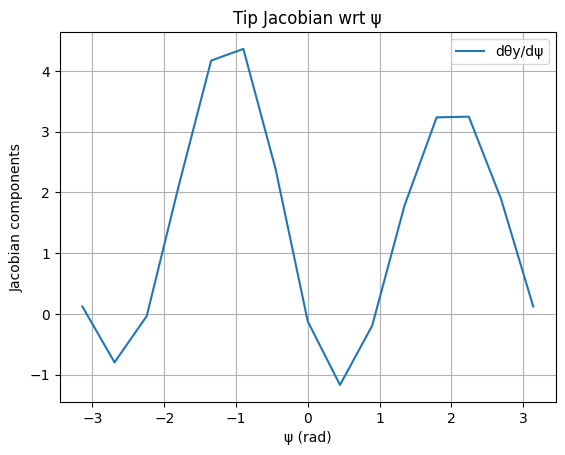

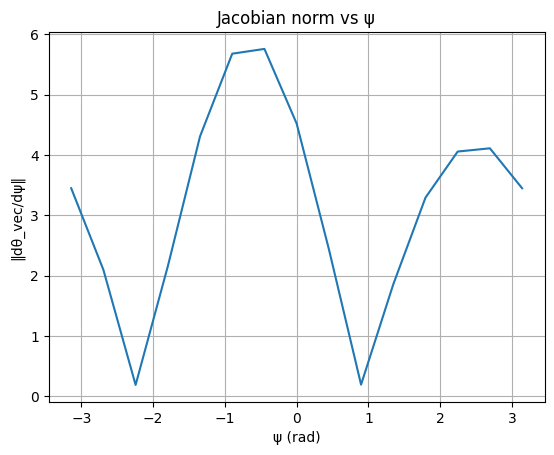

In [337]:
ks = np.linspace(-300, 300, 81) 
s_steps = 200
p_vec = np.array([0.0, 0.19, 0.0])
psi_grid = np.linspace(-np.pi, np.pi, 15)
psi0 = 0
theta_L0, k_star, sol = shooting_solve(ks, s_steps, p_vec, phi, psi0)
s_L = sol.t[-1]

jacobians = []
for psi in psi_grid:
    Jv = jacobian_tip_wrt_psi(sol, psi, p_vec,s_L=s_L,phi=phi)
    jacobians.append(Jv)


jacobians = np.asarray(jacobians)

plt.figure()
# plt.plot(psi_grid, jacobians[:,0], label='dθx/dψ')
plt.plot(psi_grid, jacobians[:,1], label='dθy/dψ')
# plt.plot(psi_grid, jacobians[:,2], label='dθz/dψ')
plt.xlabel("ψ (rad)")
plt.ylabel("Jacobian components")
plt.title("Tip Jacobian wrt ψ")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(psi_grid, np.linalg.norm(jacobians, axis=1))
plt.xlabel("ψ (rad)")
plt.ylabel("‖dθ_vec/dψ‖")
plt.title("Jacobian norm vs ψ")
plt.grid(True)
plt.show()


2
2
2
2
2
2


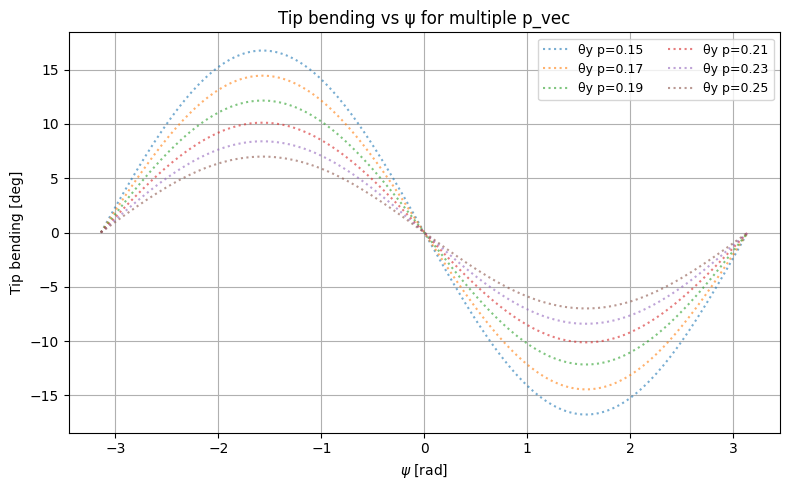

In [335]:
def sweep_tip_vs_psi_multi(ks, s_steps, p_vecs, psi_grid, labels=None, plot_components=True, phi=phi):

    psi0 = 0.0  



    plt.figure(figsize=(8,5))
    p_vec_list = []
    for y in p_vecs:
        p_vec_1 = np.array([0.0, y, 0.0])
        p_vec_list.append(p_vec_1)
        if labels is None:
            labels = [f"p={y}" for y in p_vecs]
    for p_vec, lab in zip(p_vec_list, labels):
        _, vbar_tip, _, _ = simulate_beam(ks, s_steps, psi0, np.asarray(p_vec, float), phi)

        tips = np.array([vbar_tip * m_dir_from_psi(psi,phi) for psi in psi_grid])  # (Nψ, 3)

        # plt.plot(psi_grid, np.rad2deg(tip_mag), label=f"|θ_tip| {lab}", linewidth=1.8)

        if plot_components:
            # plt.plot(psi_grid, np.rad2deg(tips[:,0]), linestyle="--", alpha=0.6, label=f"θx {lab}")
            plt.plot(psi_grid, np.rad2deg(tips[:,1]), linestyle=":",  alpha=0.6, label=f"θy {lab}")

    plt.xlabel(r"$\psi$ [rad]")
    plt.ylabel("Tip bending [deg]")
    plt.title("Tip bending vs ψ for multiple p_vec")
    plt.grid(True)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

psi_grid = np.linspace(-np.pi, np.pi, 200)
ks = np.linspace(-200, 200, 81)
s_steps = 300

ys = np.array([0.15, 0.17, 0.19, 0.21, 0.23, 0.25])
# ys = np.array([0.19])

# labels = ["y=0.19", "y=0.21"]

sweep_tip_vs_psi_multi(ks, s_steps, ys, psi_grid, plot_components=True, phi=0)


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


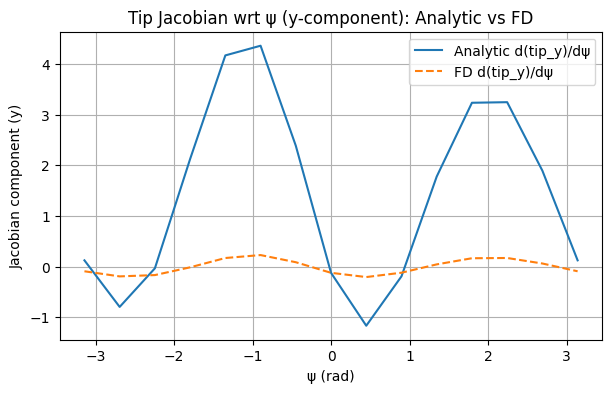

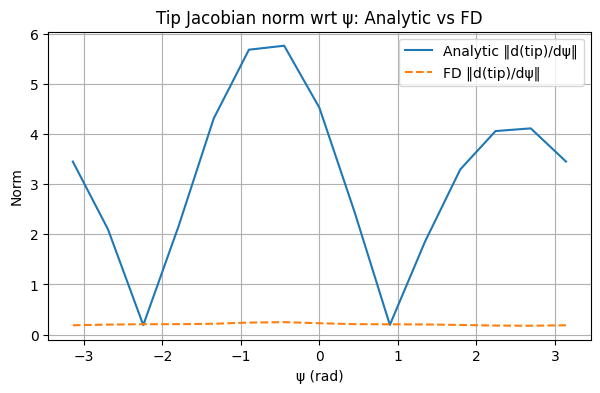

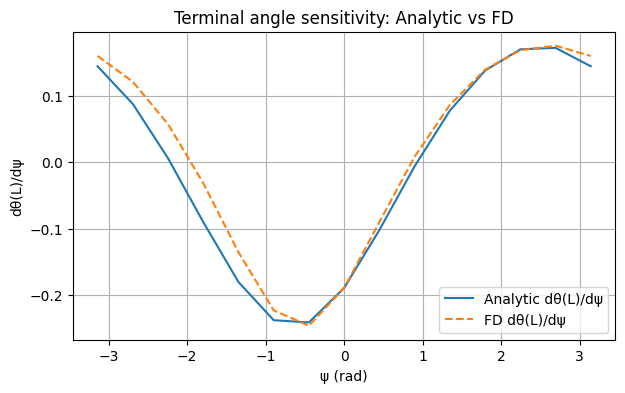

In [ ]:

def theta_L_of_psi(psi, p_vec, phi, ks, s_steps):
    """Solve the BVP at a given psi and return the terminal angle theta(L)."""
    theta_L, k_star, sol = shooting_solve(ks, s_steps, p_vec, phi, psi)
    return float(np.asarray(sol.y)[0, -1]), sol

def tip_vec_of_psi(psi, p_vec, phi, ks, s_steps):
    """
    Return the 3D tip vector used in your Jacobian plotting (vbar_tip * m_hat(psi)).
    """
    _, vbar_tip, _, _ = simulate_beam(ks, s_steps, psi=psi, p_vec=p_vec, phi=phi)
    return vbar_tip * m_dir_from_psi(psi, phi)  # same construction you used elsewhere

def dthetaL_dpsi_fd(psi, p_vec, phi, ks, s_steps, h=1e-3):
    """Finite-difference approximation of dθ(L)/dψ."""
    th_p, _ = theta_L_of_psi(psi + h, p_vec, phi, ks, s_steps)
    th_m, _ = theta_L_of_psi(psi - h, p_vec, phi, ks, s_steps)
    return (th_p - th_m) / (2*h)

def djac_tipvec_dpsi_fd(psi, p_vec, phi, ks, s_steps, h=1e-3):
    """
    Finite-difference approximation of d(tip_vec)/dψ (component-wise).
    Uses the same tip vector definition you plot (vbar_tip * m_hat(psi)).
    """
    v_p = tip_vec_of_psi(psi + h, p_vec, phi, ks, s_steps)
    v_m = tip_vec_of_psi(psi - h, p_vec, phi, ks, s_steps)
    return (v_p - v_m) / (2*h)



ks = np.linspace(-300, 300, 81)
s_steps = 200
p_vec = np.array([0.0, 0.19, 0.0])
psi_grid = np.linspace(-np.pi, np.pi, 15)
psi0 = 0.0

theta_L0, k_star, sol0 = shooting_solve(ks, s_steps, p_vec, phi, psi0)
s_L = sol0.t[-1]

jac_analytic = []
jac_fd = []
dtheta_dpsi_analytic = []
dtheta_dpsi_fd_vals = []

for psi in psi_grid:
    Jv = jacobian_tip_wrt_psi(sol0, psi, p_vec, s_L=s_L, phi=phi)
    jac_analytic.append(Jv)

    Jv_fd = djac_tipvec_dpsi_fd(psi, p_vec, phi, ks, s_steps, h=1e-3)
    jac_fd.append(Jv_fd)

    dth = tip_sensitivity_with_shooting(sol0, psi, p_vec, phi)
    dtheta_dpsi_analytic.append(dth)

    dth_fd = dthetaL_dpsi_fd(psi, p_vec, phi, ks, s_steps, h=1e-3)
    dtheta_dpsi_fd_vals.append(dth_fd)

jac_analytic = np.asarray(jac_analytic) 
jac_fd       = np.asarray(jac_fd)
dtheta_dpsi_analytic = np.asarray(dtheta_dpsi_analytic)
dtheta_dpsi_fd_vals  = np.asarray(dtheta_dpsi_fd_vals)


skip = 0  
plt.figure(figsize=(7,4))
plt.plot(psi_grid[skip:], jac_analytic[skip:, 1], label='Analytic d(tip_y)/dψ')
plt.plot(psi_grid[skip:], jac_fd[skip:, 1], '--', label='FD d(tip_y)/dψ')
plt.xlabel("ψ (rad)")
plt.ylabel("Jacobian component (y)")
plt.title("Tip Jacobian wrt ψ (y-component): Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(psi_grid[skip:], np.linalg.norm(jac_analytic[skip:], axis=1), label='Analytic ‖d(tip)/dψ‖')
plt.plot(psi_grid[skip:], np.linalg.norm(jac_fd[skip:], axis=1), '--', label='FD ‖d(tip)/dψ‖')
plt.xlabel("ψ (rad)")
plt.ylabel("Norm")
plt.title("Tip Jacobian norm wrt ψ: Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(psi_grid[skip:], dtheta_dpsi_analytic[skip:], label='Analytic dθ(L)/dψ')
plt.plot(psi_grid[skip:], dtheta_dpsi_fd_vals[skip:], '--', label='FD dθ(L)/dψ')
plt.xlabel("ψ (rad)")
plt.ylabel("dθ(L)/dψ")
plt.title("Terminal angle sensitivity: Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()


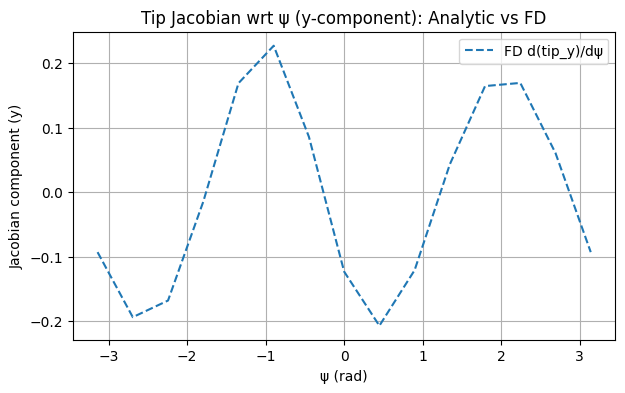

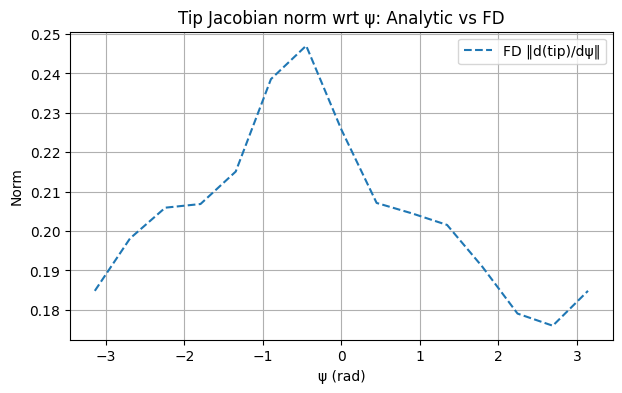

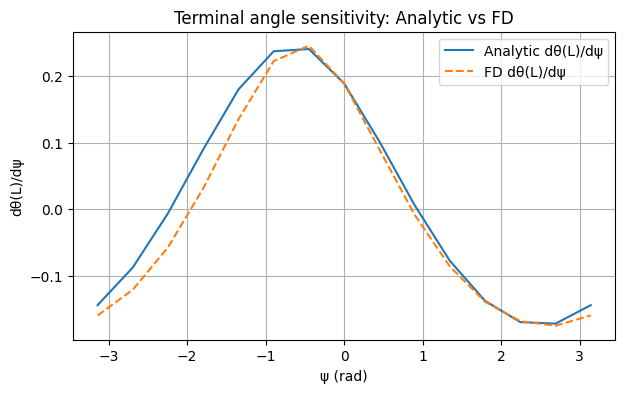

In [ ]:
plt.figure(figsize=(7,4))
# plt.plot(psi_grid[skip:], jac_analytic[skip:, 1], label='Analytic d(tip_y)/dψ')
plt.plot(psi_grid[skip:], jac_fd[skip:, 1], '--', label='FD d(tip_y)/dψ')
plt.xlabel("ψ (rad)")
plt.ylabel("Jacobian component (y)")
plt.title("Tip Jacobian wrt ψ (y-component): Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
# plt.plot(psi_grid[skip:], np.linalg.norm(jac_analytic[skip:], axis=1), label='Analytic ‖d(tip)/dψ‖')
plt.plot(psi_grid[skip:], np.linalg.norm(jac_fd[skip:], axis=1), '--', label='FD ‖d(tip)/dψ‖')
plt.xlabel("ψ (rad)")
plt.ylabel("Norm")
plt.title("Tip Jacobian norm wrt ψ: Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(psi_grid[skip:], -1*dtheta_dpsi_analytic[skip:], label='Analytic dθ(L)/dψ')
plt.plot(psi_grid[skip:], -1*dtheta_dpsi_fd_vals[skip:], '--', label='FD dθ(L)/dψ')
plt.xlabel("ψ (rad)")
plt.ylabel("dθ(L)/dψ")
plt.title("Terminal angle sensitivity: Analytic vs FD")
plt.grid(True)
plt.legend()
plt.show()